In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

In [46]:
# Step 1
# Importing the data

In [47]:
df = pd.read_csv("./data/fer2013/fer2013/fer2013.csv")
sols = pd.read_csv("./data/Submission.csv")

In [48]:
#  (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
print("Emotions: ", set(df['emotion']))

emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

Emotions:  {0, 1, 2, 3, 4, 5, 6}


In [49]:
# Checking if data needs to be cleaned
sum_ = 0
for col in df.columns:
    sum_ += df[col].isnull().sum()
print(sum_)

In [51]:
# No missing values, and a quick glance through the entries tells me we should be good
# Let's display some images, and find out what emotions 0-6 represent

In [52]:
"""
    Turns strings into intiger arrays or matrices
    if matrix_boolean=True, a matrix is returned
    if normalize_boolean=True, each value is between [0, 1] instead of [0, 255]
    when nparray_boolean is true, a np.array() is returned, otherwise a list (same goes for matrix format) 
"""
def string_to_intarray(pix, matrix_boolean=True, normalize_boolean=False, nparray_boolean=True):
    # The string is shaped: "num1 num2 num3 ... numn"
    # Splitting at each space gives a list ["num1", "num2", ..., "numn"]
    pix = pix.split(" ")

    # Creating a numpy array by reading each number string p as an integer
    pix = np.array([int(p) for p in pix])

    # # Checking the shape to decide on the matrix format
    # print(pix.shape)

    # Dataset metadata says pictures are 48x48 -> rescale
    if matrix_boolean:
        pix = pix.reshape((48, 48, 1))
    # print(pix.shape)

    # for tensorflow we need values in range [0, 1] not [0, 255]
    if normalize_boolean:
        pix = pix/255

    # apparently tensorflow doesn't want nparrays, just matrices
    if not nparray_boolean:
        pix = pix.tolist()

    return pix

# Loading a set of pixels from the dataset, as a string
pix = df["pixels"].iloc[0]
pix = string_to_intarray(pix, True)

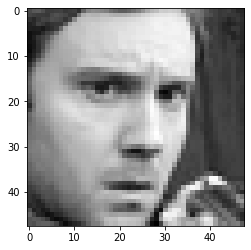

In [53]:
# Looking good
plt.imshow(pix, cmap='gray')

In [55]:
# Complete preprocessing. All pixel entries should be vectors of integers
for index, row in df.iterrows():
    row[1] = string_to_intarray(row[1], True, True, False)
    df.iloc[index] = row

In [62]:
# Step 2: Parsing the data to h5py format as mentioned in the assignment
# Tensorflow should have readily available methods

# Update: Looks like tensorflow doesn't need h5py
# Create training and testing dataframes
# df_train = all rows of df where Usage=="Training"
df_train = df[df["Usage"]=="Training"]
# Sanity check
print(set(df_train["Usage"]))

# repeating process for the test sets
print(set(df["Usage"]))
df_prt = df[df["Usage"]=="PrivateTest"]
df_put = df[df["Usage"]=="PublicTest"]

{'Training'}
{'Training', 'PrivateTest', 'PublicTest'}


In [73]:
df_train["pixels"].iloc[0]

# Following along with a tutorial for this part https://www.tensorflow.org/tutorials/load_data/csv
# Turning the training set into a pixels array and a labels array

# Slicing the start only s.t. running times are lower
train_pix = list(df_train["pixels"])
train_labels = list(df_train["emotion"])


test_pr_pix = list(df_prt["pixels"])
test_pr_labels = list(df_prt["emotion"])
test_pu_pix = list(df_put["pixels"])
test_pu_labels = list(df_put["emotion"])


In [74]:
# Now creating the CNN, following along with https://www.tensorflow.org/tutorials/images/cnn

model = models.Sequential()
# Adds a convolutional layer with 32 filters and kernel size 3x3
model.add(layers.Conv2D(48, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(96, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(96, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(96, activation='relu'))
model.add(layers.Dense(10))

In [75]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 46, 46, 48)        480       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 48)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 21, 21, 96)        41568     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 96)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 96)          83040     
_________________________________________________________________
flatten_5 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 96)               

In [76]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_pix, train_labels, epochs=10,
                    validation_data=(test_pr_pix, test_pr_labels))

In [ ]:
val = model.predict(test_pu_pix[0])
print(val)

In [ ]:
val = emotions[val]
plt.imshow(test_pu_pix[0])

plt.label("Pred: ", val, "Ref: ", test_pu_labels[0])